# Assignment 3: Molecular Dynamics
## Martin Colahan


## Instructions:

This notebook is hosted on Github: [Github](https://github.com/mcolahan/mole-sim)
and can be accessed through the binder button on the README.md file or at the following link:[Code can be run here](https://mybinder.org/v2/gh/mcolahan/mole-sim/master?filepath=MD%20Assignment%203.ipynb)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/mcolahan/mole-sim/master?filepath=MD%20Assignment%203.ipynb)

The notebook can also be downloaded from Github and run locally using Jupyter. The easiest way to set up the environment is to install python via Anaconda.

To run a code cell, click on the cell and press Shift+Enter.

## Python and package versions:


In [1]:
import sys
import numpy
import matplotlib

print(f'Python: {sys.version}')
print(f'Numpy: {numpy.__version__}')
print(f'Matplotlib: {matplotlib.__version__}')

Python: 3.7.2 (default, Feb 21 2019, 17:35:59) [MSC v.1915 64 bit (AMD64)]
Numpy: 1.16.2
Matplotlib: 3.0.2


# Assigment Info:
## Q1 
<ol> <li type="a"> 
    Adapt microcanonical ensemble MD code from 2nd assignment to calculate instantaneous temperature and pressure and output it with potential, kinetic, and total energies.
    </li>
<li type="a"> 
    Use a Berendsen thermostat to simulate a canonical ensemble.
</li>
</ol>

## Q2
<ol>
    <li type="a">
        Use the canonical ensemble code to simulate many different state points (P,T, $\rho$).Estimate van der Waals EOS coefficients. 
    </li>
    <li type="a">
        Use the EOS from (a) to predict P at T = 0.7 and $\rho$ = 1.0. Check with a MD simulation to determine difference from prediction.  
    </li>
    <li type="a">
        Calculate the radial distribution function for T=0.7 and $\rho$ = 1
    </li>


# Code

In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def Lennard_Jones(r, dist_cutoff=3):
    # r is a 2D array where row i, and col j correspond to particle i and dimension j (x:0, y:1, z:2)
    # outputs: a 3D array where f[i,j,k] is the force on i because of j in dimension k,
    # sum of potential energy, and virial for instantaneous pressure calcs
    
    #             part i    part j  (x,y,z)

    f = np.zeros([n_parts, n_parts, n_dims])
    E_p_sum = 0
    
    virial = 0    # for pressure calculation
    
    for i in range(n_parts):
        # get position vectors and distances between particles 
        r_ij_vect = r[i,:] - r[(i+1):,:]   
        r_ij_vect -= np.around(r_ij_vect / box_size) * box_size   #pbc
        
        r_ij = np.sqrt(np.sum(r_ij_vect**2, axis=1))   # magnitude (norm) of r_ij_vect

        # get index of particles within range of the spherical cutoff
        parts_in_range = np.where(r_ij <= dist_cutoff)[0]
        
        # distance magnitude of particles within the spherical cutoff
        r_near = r_ij[parts_in_range]   
        
        # Lennard Jones
        # eq 5.3 in Allen and Tildesley 2nd ed
        # fij = -du(rij)/dr * unit vector of r_ij_vect
        f_mag = np.zeros([n_parts-i-1])
        f_mag[parts_in_range] = 24 * epsilon / r_near * (2 *
                (sigma/r_near) ** 12 - (sigma/r_near) ** 6)
                
        # new axis converts 1D array to a 2D array 
        f_vect = f_mag[:, np.newaxis] * r_ij_vect/r_ij[:, np.newaxis]
        f[i, (i+1):, :] =  f_vect
        f[(i+1):, i, :] = -f_vect   # newton's 3rd law
        
        
        virial += np.sum(r_ij_vect * f_vect)
        
        Ep = np.zeros([n_parts - i - 1])
        Ep[parts_in_range] = 4 * epsilon * ((sigma/r_near) ** 12 - (sigma/r_near) ** 6)
        
        E_p_sum += np.sum(Ep)

    virial = virial / 3
    return f, E_p_sum, virial


def molecular_dynamics(part_props, ensemble, box_size, time_props, Tsp=None, deltat_tao = 0.005, save_csv=False, sim_name=""):
    global n_parts, n_dims, sigma, epsilon, m

    epsilon = part_props['epsilon']
    sigma = part_props['sigma']
    m = part_props['mass']
    number_density = part_props['density']
    min_dist = part_props['min_dist']      # minimum distance between particles in initialization
    
    n_dims = len(box_size)

    delta_t = time_props['delta_t']        # time between time steps
    n_timesteps = time_props['timesteps']     # how many time steps?
    output_steps = time_props['steps between out']
    dist_cutoff = 3 * sigma
    
    time =  np.arange(0, n_timesteps * delta_t, delta_t)
    time_out = time[::output_steps]   # get time after output_steps steps 
    n_outputs = np.shape(time_out)[0]
    
    # Ensemble considerations:
    if ensemble == 'Microcanonical':
        const_T = False
    elif ensemble == 'Canonical':
        const_T = True
    else:
        raise ValueError('Ensemble type not defined.')
        

    ## Initialization and determining particle starting locations (from assignment 1)

    n_parts = int(number_density * np.prod(box_size))
    
    V = np.prod(box_size)
    Kb = 1
    
    init_locs = np.random.rand(n_parts, n_dims) * box_size
    min_dists = []
    for i in range(n_parts):
        continue_looping = True
        if i == 0:
            continue
        loop_count = 0
        while continue_looping == True:
            if loop_count > 10000:
                raise InterruptedError('Loop was interrupted')

            dr = init_locs[i,:] - init_locs[:i,:]
            dr = dr - np.around(dr / box_size) * box_size   # PBC 
            dist = np.sqrt(np.sum(dr**2, axis=1))

            if (dist < min_dist).any() == True:
                init_locs[i, :] = np.random.rand(1, n_dims) * box_size
            else:
                continue_looping = False
                min_dists.append(min(dist))

            loop_count += 1


    ## Time Integration

    #initialize position and velocity arrays (indices of arrays: particles, dimensions, time)
    # e.g., r[i, :, k] is position of particle i in all dimensions (x, y, z) at time k
    r = np.zeros([n_parts, n_dims, n_timesteps+1])   
    r[:, :, 0] = init_locs
    v = np.zeros([n_parts, n_dims, n_timesteps+1])
    a = np.zeros([n_parts, n_dims])

    # outputs init
    r_out = np.zeros([n_parts, n_dims, n_outputs])
    v_out = np.zeros([n_parts, n_dims, n_outputs])
    Ep = np.zeros(n_outputs)
    Ek = np.zeros(n_outputs)
    E = np.zeros(n_outputs)
    P = np.zeros(n_outputs)
    T = np.zeros(n_outputs)
    
    out_iter = 0

#     printed = False    # for debugging purposes

    for t in time:
        if t == 0:
            r = init_locs
            v = np.zeros([n_parts, n_dims])
            
            # Calculate initial acceleration
            f, pot_energy, virial = Lennard_Jones(r[:,:], dist_cutoff=dist_cutoff)
            f_vect = np.sum(f, axis=1) 
            a_vect = f_vect / m
            

        # using velocity-verlet algorithm
        v_halfdt = v + 0.5*delta_t * a_vect
        r = r + delta_t * v_halfdt

        # check if out of box and update if so
        r = r - np.floor(r / box_size) * box_size

        # update forces and acceleration with new r
        f, pot_energy, virial = Lennard_Jones(r)
        f_vect = np.sum(f, axis=1) 
        a_vect = f_vect / m

        v = v_halfdt + 0.5 * delta_t * a_vect

        if const_T == True:
            v_mag = np.sqrt(np.sum(v**2, axis=1))
            KE = np.sum(0.5 * m * v_mag**2)
            T_inst = 2 * KE / (3*(n_parts -1) * Kb)
            # Berendesen thermostat
            lam = np.sqrt(1 + deltat_tao * (Tsp / T_inst - 1))

            v *= lam
        
        v_mag = np.sqrt(np.sum(v**2, axis=1))
        KE = np.sum(0.5 * m * v_mag**2)
        T_inst = 2 * KE / (3*(n_parts -1) * Kb) 
        
        P_inst = number_density * T_inst + virial/V
        
        if t in time_out:
            r_out[:,:,out_iter] = r
            v_out[:,:,out_iter] = v
            Ek[out_iter] = KE
            Ep[out_iter] = pot_energy
            E[out_iter] = KE + pot_energy
            T[out_iter] = T_inst
            P[out_iter] = P_inst
            
            out_iter += 1

    if save_csv == True:
        cols = ['t', 'E', 'Ek', 'Ep', 'T', 'P']
        out_df = pd.DataFrame(np.array([time_out, E, Ek, Ep, T, P]).T, columns=cols)
        
        time_df = pd.DataFrame(time_out, columns=pd.MultiIndex.from_tuples([('t','t')]))

        dims = ['x', 'y', 'z']
        mult_ind = pd.MultiIndex.from_product([np.arange(n_parts), dims])
        r_df = pd.DataFrame(columns=mult_ind)
        r_df = pd.concat([time_df, r_df])
        v_df = r_df.copy()
        for i in range(n_outputs):
            for part in range(n_parts):
                r_df.loc[i, [part][:]] = r_out[part, :, i] 
                v_df.loc[i, [part][:]] = v_out[part, :, i]
                
        r_df.to_csv(sim_name + ' - position.csv')
        v_df.to_csv(sim_name + ' - velocity.csv')
        out_df.to_csv(sim_name + ' - ETP.csv')

    else:
        return time_out, r_out, v_out, E, Ek, Ep, T, P
            
            


box_size = np.array([8,8,8])    # (x, y, z)
part_props = {
    'epsilon': 1,
    'sigma': 1, 
    'mass': 1,
    'density': 1,
    'min_dist': 0.8,
}
time_props = {
    'delta_t': 0.001,
    'timesteps': 100,
    'steps between out': 2    # output every n_steps steps 
}

# t, r, v, E, Ek, Ep, T, P = molecular_dynamics(part_props, 'Canonical', box_size, time_props, Tsp=3, save_csv=False)
# out_df = molecular_dynamics(part_props, 'Canonical', box_size, time_props, Tsp=3, save_csv=True, sim_name='test')

# out_df


# ## Post Processing
# # plot energies, Temp, and Pressure
# plt.figure(figsize=[9,4])
# # left plot
# plt.subplot(121)

# plt.plot(t, Ek, label='Kinetic', c='C0')
# plt.plot(t, Ep, label='Potential', c='C3')
# plt.plot(t, E, label='Total', c='C4')
# plt.ylabel('Energy')
# plt.xlabel('Time')
# plt.legend(frameon=False)

# # right plot
# ax_l = plt.subplot(122)
# temp=plt.plot(t[5:], T[5:], label='Temperature', c='C0')
# plt.ylabel('Temperature')
# plt.xlabel('Time')
# ax_r = ax_l.twinx()
# pres=plt.plot(t[5:], P[5:], label='Pressure', c='C3')
# plt.ylabel('Pressure')
# lines = temp + pres
# labels = [l.get_label() for l in lines]
# ax_l.legend(lines, labels,frameon=False)

# plt.tight_layout()
# plt.show()


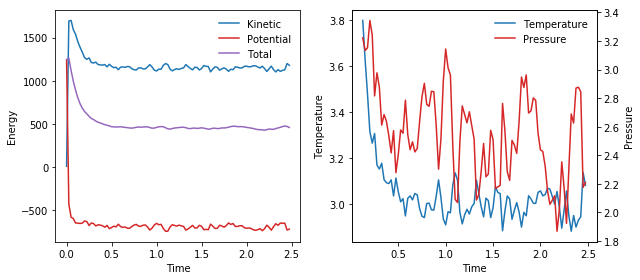

In [115]:
%matplotlib inline

box_size = np.array([8,8,8])    # (x, y, z)
part_props = {
    'epsilon': 1,
    'sigma': 1, 
    'mass': 1,
    'density': 0.5,
    'min_dist': 0.8,
}
time_props = {
    'delta_t': 0.0005,
    'timesteps': 5000,
    'steps between out': 50    # output every n_steps steps 
}

t, r, v, E, Ek, Ep, T, P = molecular_dynamics(part_props, 'Canonical', box_size, time_props, Tsp=3)


## Post Processing
# plot energies, Temp, and Pressure
plt.figure(figsize=[9,4])
# left plot
plt.subplot(121)

plt.plot(t, Ek, label='Kinetic', c='C0')
plt.plot(t, Ep, label='Potential', c='C3')
plt.plot(t, E, label='Total', c='C4')
plt.ylabel('Energy')
plt.xlabel('Time')
plt.legend(frameon=False)

# right plot
ax_l = plt.subplot(122)
temp=plt.plot(t[5:], T[5:], label='Temperature', c='C0')
plt.ylabel('Temperature')
plt.xlabel('Time')
ax_r = ax_l.twinx()
pres=plt.plot(t[5:], P[5:], label='Pressure', c='C3')
plt.ylabel('Pressure')
lines = temp + pres
labels = [l.get_label() for l in lines]
ax_l.legend(lines, labels,frameon=False)

plt.tight_layout()
plt.show()

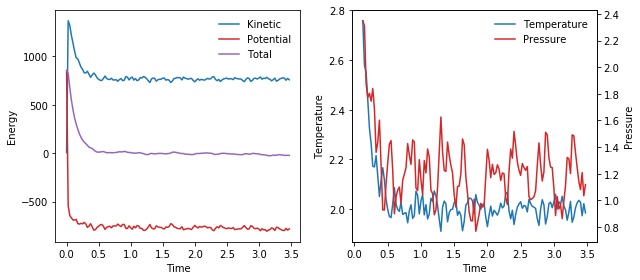

In [116]:
%matplotlib inline

box_size = np.array([8,8,8])    # (x, y, z)
part_props = {
    'epsilon': 1,
    'sigma': 1, 
    'mass': 1,
    'density': 0.5,
    'min_dist': 0.8,
}
time_props = {
    'delta_t': 0.0005,
    'timesteps': 7000,
    'steps between out': 50    # output every n_steps steps 
}

t, r, v, E, Ek, Ep, T, P = molecular_dynamics(part_props, 'Canonical', box_size, time_props, Tsp=2)


## Post Processing
# plot energies, Temp, and Pressure
plt.figure(figsize=[9,4])
# left plot
plt.subplot(121)

plt.plot(t, Ek, label='Kinetic', c='C0')
plt.plot(t, Ep, label='Potential', c='C3')
plt.plot(t, E, label='Total', c='C4')
plt.ylabel('Energy')
plt.xlabel('Time')
plt.legend(frameon=False)

# right plot
ax_l = plt.subplot(122)
temp=plt.plot(t[5:], T[5:], label='Temperature', c='C0')
plt.ylabel('Temperature')
plt.xlabel('Time')
ax_r = ax_l.twinx()
pres=plt.plot(t[5:], P[5:], label='Pressure', c='C3')
plt.ylabel('Pressure')
lines = temp + pres
labels = [l.get_label() for l in lines]
ax_l.legend(lines, labels,frameon=False)

plt.tight_layout()
plt.show()

# Q2
Estimation of van der Waals coefficients 

In [70]:
box_size = np.array([8,8,8])    # (x, y, z)
part_props = {
    'epsilon': 1,
    'sigma': 1, 
    'mass': 1,
    'density': 0.5,
    'min_dist': 0.8,
}
time_props = {
    'delta_t': 0.001,
    'timesteps': 2000,
    'steps between out': 100    # output every n_steps steps 
}

densities = np.array([0.2, 0.5, 0.8, 1.2])
temps = np.linspace(0.8, 3, 5)
conditions = []
for i in densities:
    for j in temps:
        conditions.append((round(i,2),round(j,2)))

Pcalced = []
#time_out, r_out, v_out, E, Ek, Ep, T, P
break_cond = False

P_list = []
i = 0
for cond in conditions:
    rho = cond[0]
    T = cond[1]
    part_props['density'] = rho
    
    _, _, _, _, _, _, _, P = molecular_dynamics(part_props, 'Canonical', box_size, time_props, Tsp=T, save_csv=False)
        
    P_list.append(P)

cols = pd.MultiIndex.from_tuples(conditions)
P_df = pd.DataFrame(np.array(P_list).T,columns=cols)
P_df.head()



0.2                                                0.5             \
       0.80      1.35      1.90      2.45      3.00       0.80       1.35   
0  2.311760  1.740084  2.961035  1.680216  2.988041  15.975894  18.558911   
1  0.306928  0.016179  0.376441  0.111037  0.487169   2.382122   3.183481   
2 -0.033793  0.119987  0.330672  0.285151  0.689748   1.837543   2.425726   
3  0.105963  0.160633  0.556297  0.247068  0.846157   0.860021   1.610246   
4  0.071504  0.208195  0.387520  0.462666  0.664178   0.476873   1.624502   

                                          0.8                        \
        1.90       2.45       3.00       0.80       1.35       1.90   
0  15.481075  13.246103  17.267311  49.958562  51.460216  49.087733   
1   2.760783   2.847743   3.483937  15.049855  16.043905  15.594928   
2   2.389286   2.139758   3.183460  12.200158  12.531349  12.616232   
3   1.835432   2.175987   2.879945   9.560395   9.595369  11.315283   
4   1.478349   2.216617   2.688988   6.842683   8.034604   9.130862   

                                1.2                                      \
        2.45       3.00        0.80        1.35        1.90        2.45   
0  47.847420  52.593948  162.814055  167.517905  160.386760  166.318532   
1  16.362625  17.512680   85.598367   87.550778   85.490760   90.173231   
2  13.973830  15.760125   73.081580   77.089751   78.391534   79.463917   
3  12.403226  14.013424   66.306726   68.091773   68.330668   70.372179   
4  10.642947  12.383968   57.761004   60.219495   63.019705   66.273226   

               
         3.00  
0  157.039540  
1   87.037522  
2   78.679760  
3   73.003045  
4   69.150565

In [90]:
from scipy.optimize import least_squares

def vanderWaals(a, b, T, rho):
    return T / (1/rho - b) - a*rho

def difference(x, T, P_sim, rho):
    a = x[0]
    b = x[1]

    diff = vanderWaals(a, b, T, rho) - P_sim
    return diff

a_mod = []
b_mod = []
for rho in densities:
    P_rho = P_df[rho]
    
    P_avgs = []
    for T in temps:
        # find average P
        P_over_time = P_rho[round(T,2)].values
        half_ind = int(len(P_over_time)/2)
        P_avgs.append(P_over_time[half_ind:].mean())
    
    
    res = least_squares(difference, (1,1), args=(temps, P_avgs, rho), verbose=0)
    a_mod.append(res.x[0])
    b_mod.append(res.x[1])
    
a_mod = a_mod[:-1]
b_mod = b_mod[:-1]
a_mod = sum(a_mod) / len(a_mod)
b_mod = sum(b_mod) / len(b_mod)

T = 0.7
rho = 1
P_predict =vanderWaals(a_mod, b_mod, T, rho)
print(P_predict)

-5.313419629650379


In [87]:
box_size = np.array([8,8,8])    # (x, y, z)
part_props = {
    'epsilon': 1,
    'sigma': 1, 
    'mass': 1,
    'density': 1,
    'min_dist': 0.8,
}
time_props = {
    'delta_t': 0.0005,
    'timesteps': 7000,
    'steps between out': 50    # output every n_steps steps 
}

_, r, _, _, _, _, _, P = molecular_dynamics(part_props, 'Canonical', box_size, time_props, Tsp=0.7)
Psim = P[int(len(P)/2):].mean()
print(Psim)

5.4771848534743555


### Pair Distribution Function: $g(r)$

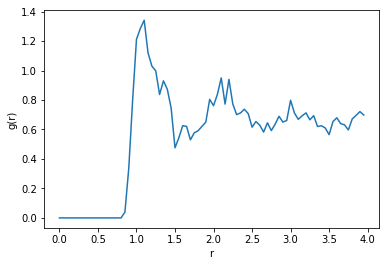

In [150]:
density = 1
ro = r[:,:,70:]
n_times = np.shape(ro)[2]
n_parts = np.shape(ro)[1]
delta_r = 0.05
max_r = 4
# bins_array = np.zeros(max_r / delta_r)
max_vals = np.arange(0, max_r + delta_r, delta_r)   #doesnt include 4.1
bins_array = np.zeros(len(max_vals)-1)

for m in range(n_times):
    rom = ro[:,:,m]
    for i in range(n_parts-1):
        r_ij_vect = rom[i,:] - rom[(i+1):,:]   
        r_ij_vect -= np.around(r_ij_vect / box_size) * box_size   #pbc

        r_ij = np.sqrt(np.sum(r_ij_vect**2, axis=1))   # magnitude (norm) of r_ij_vect

        k = np.floor(r_ij / delta_r)

        for val in k:
            if val <= (len(bins_array) - 1):
                bins_array[int(val)] += 2


num = bins_array / (n_parts * n_times)
 
i = 0
g = []
for val in max_vals:

    if val == max_vals[0]:
        old_val = val
        continue
    
    
    h = 4 * np.pi * density / 3  * (val**3 - old_val**3)
    
    g.append(num[i] / h)
    old_val = val
    i += 1
    
plt.figure()
plt.subplot(111)
plt.plot(max_vals[:-1], g) 
plt.xlabel('r')
plt.ylabel('g(r)')
plt.show()
